In [1]:
import pandas as pd
from datetime import timedelta, date
import matplotlib.pyplot as plt
import numpy as np
from scipy import signal

plt.rcParams['text.usetex'] = False

In [2]:
def extract_time_block(min_t, max_t, table):
    
    return table.query("date>=@min_t & date<=@max_t")

In [125]:
def batter_power(delta_freq):
    
    charge_efficiency = 0.9
    alpha_upper = 0.95/0.3
    alpha_lower = 0.05/0.2
    
    ccharge_upper = 1 - 0.5 * alpha_upper
    
    if delta_freq >= 0.2:
        battery_charge = ccharge_upper + alpha_upper * delta_freq
    elif delta_freq <= -0.2:
        battery_charge = -ccharge_upper + alpha_upper * delta_freq
    elif delta_freq >= 0.015:
        battery_charge = alpha_lower * delta_freq
    elif delta_freq <= -0.015:
        battery_charge = alpha_lower * delta_freq
    else:
        battery_charge = 0
        
    if abs(battery_charge)>1.0:
        battery_charge = battery_charge / abs(battery_charge)
        
    if battery_charge > 0.0:
        battery_charge = charge_efficiency * battery_charge
        
    return battery_charge
        

In [12]:
freq_table = pd.read_csv("task_data_1hz.csv")

In [13]:
freq_table = freq_table.rename(
    {
        "datetime": "date",
        "f_hz": "freq"
    }, axis=1
)

In [14]:
freq_table["date"] = freq_table["date"].astype("datetime64[ns]")

In [15]:
freq_table["delta_freq"] = freq_table["freq"] - 50

freq_table["time"] = freq_table["date"].dt.time

In [16]:
freq_table

,date,freq,delta_freq,time
0,2021-09-01 00:00:00,49.922,-0.078,00:00:00
1,2021-09-01 00:00:01,49.917,-0.083,00:00:01
2,2021-09-01 00:00:02,49.909,-0.091,00:00:02
3,2021-09-01 00:00:03,49.903,-0.097,00:00:03
4,2021-09-01 00:00:04,49.899,-0.101,00:00:04
...,...,...,...,...
2528295,2021-09-30 06:18:15,50.089,0.089,06:18:15
2528296,2021-09-30 06:18:16,50.091,0.091,06:18:16
2528297,2021-09-30 06:18:17,50.093,0.093,06:18:17
2528298,2021-09-30 06:18:18,50.095,0.095,06:18:18


In [17]:
df = np.linspace(-0.6, 0.6, num=1000)

Text(0, 0.5, 'Charge %')

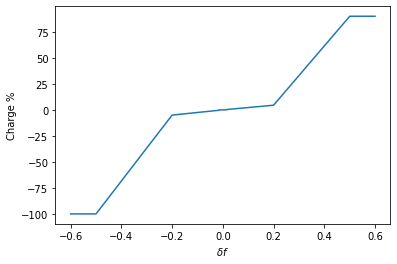

In [19]:
plt.plot(df, [100*batter_power(dfi) for dfi in df])
plt.xlabel("$\delta f$")
plt.ylabel("Charge %")

In [20]:
freq_table["battery_charge"] = [batter_power(dfi) for dfi in freq_table["delta_freq"]]

In [21]:
freq_table['date'].max()

Timestamp('2021-09-30 06:18:19')

In [22]:
freq_table.head()

,date,freq,delta_freq,time,battery_charge
0,2021-09-01 00:00:00,49.922,-0.078,00:00:00,-0.01950
1,2021-09-01 00:00:01,49.917,-0.083,00:00:01,-0.02075
2,2021-09-01 00:00:02,49.909,-0.091,00:00:02,-0.02275
3,2021-09-01 00:00:03,49.903,-0.097,00:00:03,-0.02425
4,2021-09-01 00:00:04,49.899,-0.101,00:00:04,-0.02525


array([[<AxesSubplot:title={'center':'freq'}>]], dtype=object)

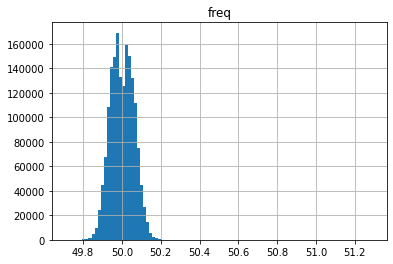

In [23]:
freq_table.hist('freq', bins=100)

<AxesSubplot:xlabel='date'>

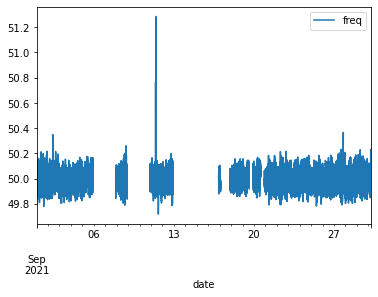

In [24]:
freq_table.plot('date', 'freq')

In [25]:
freq_table.query("freq>50.5")

,date,freq,delta_freq,time,battery_charge
898721,2021-09-11 09:38:41,50.747,0.747,09:38:41,0.9
898722,2021-09-11 09:38:42,50.765,0.765,09:38:42,0.9
900129,2021-09-11 10:02:09,51.286,1.286,10:02:09,0.9


In [26]:
len(freq_table)

2528300

In [27]:
len(freq_table.dropna())

1707500

In [28]:
freq_table.date.min()

Timestamp('2021-09-01 00:00:00')

In [29]:
freq_table.date.max()

Timestamp('2021-09-30 06:18:19')

In [30]:
max_missing = freq_table[freq_table.isnull().any(axis=1)].date.max()

In [31]:
max_missing

Timestamp('2021-09-20 21:59:59')

In [32]:
start = max_missing.date() + timedelta(days=1)

In [33]:
end = freq_table.date.max().date()

In [34]:
cont_table = extract_time_block(start, end, freq_table)

In [35]:
cont_table.date.min()

Timestamp('2021-09-21 00:00:00')

In [36]:
cont_table.date.max()

Timestamp('2021-09-30 00:00:00')

In [37]:
len(cont_table)

777601

array([[<AxesSubplot:title={'center':'freq'}>]], dtype=object)

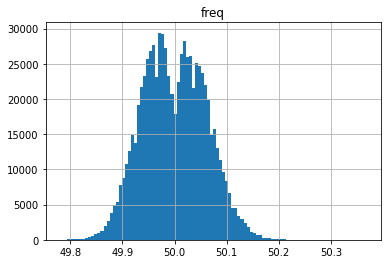

In [38]:
cont_table.hist('freq', bins=100)

<AxesSubplot:xlabel='time'>

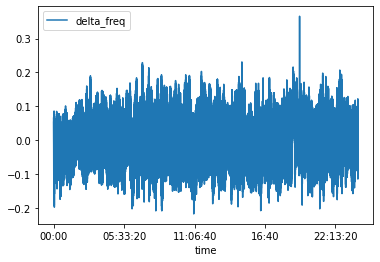

In [39]:
cont_table.plot('time', 'delta_freq')

In [40]:
fft = np.abs(np.fft.rfft(cont_table.delta_freq))**2.0

In [45]:
x, f2 = signal.welch(cont_table.delta_freq, fs=1)

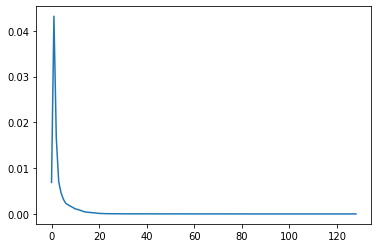

In [47]:
plt.plot(f2)

In [172]:
x, f2_orig = signal.welch(freq_table.delta_freq.fillna(0), fs=1)

In [173]:
mv = freq_table.delta_freq.mean()

In [174]:
stdv = freq_table.delta_freq.std()

In [175]:
mv / (stdv/np.sqrt(len(cont_table)))

14.860065135433008

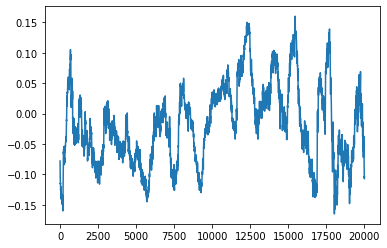

In [176]:
plt.plot(freq_table.delta_freq[:20000])

In [177]:
freq_table['noise'] = np.random.normal(0.0, stdv*0.1, len(freq_table)) 

In [178]:
freq_table['ran_fill'] = freq_table.delta_freq.fillna(freq_table['noise'])

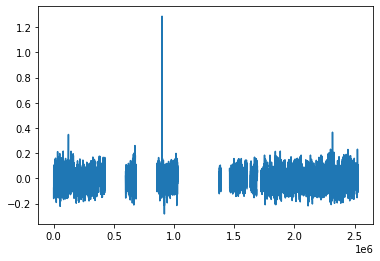

In [179]:
plt.plot(freq_table.delta_freq)

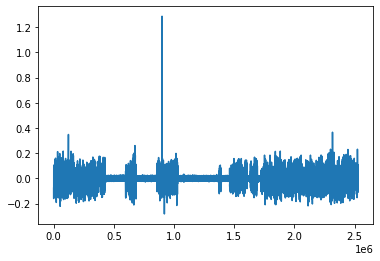

In [92]:
plt.plot(freq_table.ran_fill)

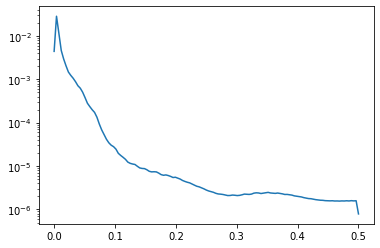

In [93]:
plt.semilogy(x, f2_orig)

In [94]:
x, f2_cut = signal.welch(cont_table.delta_freq, fs=1)

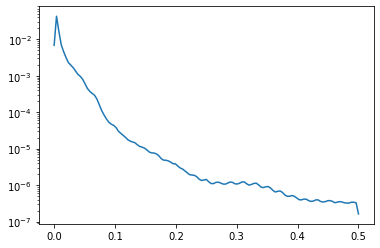

In [95]:
plt.semilogy(x, f2_cut)

In [96]:
x, f2_fill = signal.welch(freq_table.ran_fill, fs=1)

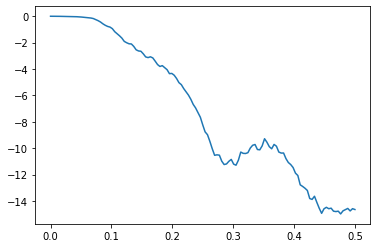

In [97]:
plt.plot(x, (f2_orig-f2_fill)/f2_orig)

In [181]:
fs = 2*np.max(x)

In [182]:
samps = np.sqrt(fs * len(f3) * f3)

In [183]:
phi = np.random.uniform(0, 2*np.pi, len(samps))

In [184]:
ran_samps = [complex(s * np.cos(p), s * np.sin(p)) for (s,p) in zip(samps, phi)]

In [185]:
ran_samps_neg = [complex(s * np.cos(p), -s * np.sin(p)) for (s,p) in zip(samps, phi)]

In [186]:
del ran_samps_neg[0]

In [187]:
ran_samps_neg.reverse()

In [188]:
rfull = ran_samps_neg + ran_samps

In [189]:
rfull.reverse()

In [190]:
len(rfull)

777601

In [191]:
rfull[0]

(-0.9226950401599534+0.46241797974920185j)

In [192]:
rfull[len(rfull)-1]

(-0.9226950401599534-0.46241797974920185j)

In [193]:
len(ran_samps)

388801

In [194]:
mock = np.fft.ifft(rfull)

In [177]:
x, f2 = signal.welch(freq_table.delta_freq.fillna(0), fs=1)

In [96]:
tn = np.random.normal(0.0, 10, size=1000000)

In [97]:
x, f2 = signal.welch(tn, fs=1)

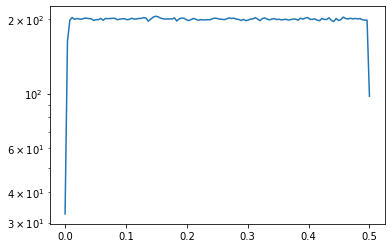

In [98]:
plt.semilogy(x, f2)

In [90]:
len(fft)

388801

In [39]:
len(f2)

129

In [40]:
from statsmodels.tsa.seasonal import seasonal_decompose

In [42]:
result = seasonal_decompose(cont_table.delta_freq, period=1)

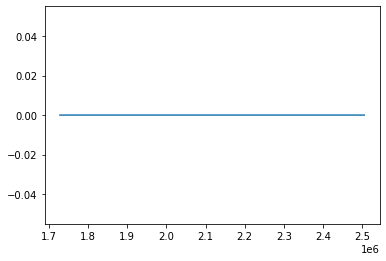

In [49]:
plt.plot(result.resid)

In [111]:
freq_table['seconds'] = freq_table.index

In [129]:
f2 = signal.lombscargle(list(freq_table.seconds), list(freq_table.delta_freq.fillna(0)), freqs=x, precenter=True, normalize=True)

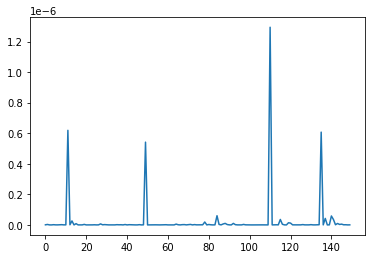

In [130]:
plt.plot(f2)

In [108]:
pd.to_timedelta(freq_table.dropna().date).dt.total_seconds()

TypeError: dtype datetime64[ns] cannot be converted to timedelta64[ns]

In [101]:
freq_table.dropna().delta_freq

0         -0.078
1         -0.083
2         -0.091
3         -0.097
4         -0.101
           ...  
2528295    0.089
2528296    0.091
2528297    0.093
2528298    0.095
2528299    0.096
Name: delta_freq, Length: 1707500, dtype: float64

In [113]:
import numpy as np
import matplotlib.pyplot as plt
rng = np.random.default_rng()

In [166]:
A = 2.
w0 = 1.  # rad/sec
nin = 150
nout = 1000

In [167]:
x = rng.uniform(0, 10*np.pi, nin)

In [168]:
y = A * np.cos(w0*x)

In [169]:
w = np.linspace(0.01, 10, nout)

In [170]:
import scipy.signal as signal
pgram = signal.lombscargle(x, y, w, normalize=True)

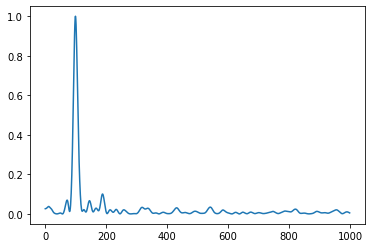

In [171]:
plt.plot(pgram)


In [165]:
pgram_l

array([8.65198901e-05, 5.92989124e-05, 2.91514324e-05, 3.66015690e-05,
       8.76164441e-05, 1.13265640e-04, 1.01321202e-04, 7.32675929e-05,
       3.93988290e-05, 2.54841366e-05, 5.58671127e-05, 1.00427967e-04,
       1.15820953e-04, 9.75168125e-05, 5.88691151e-05, 2.65946537e-05,
       3.53467868e-05, 8.13230780e-05, 1.19437424e-04, 1.20361806e-04,
       8.55704488e-05, 3.92735794e-05, 2.36469067e-05, 5.91830062e-05,
       1.12928198e-04, 1.38143353e-04, 1.16660877e-04, 6.34383126e-05,
       2.32233515e-05, 3.81490860e-05, 9.74104021e-05, 1.47805374e-04,
       1.48630550e-04, 9.80138664e-05, 3.64575788e-05, 2.29437523e-05,
       7.53281481e-05, 1.47186335e-04, 1.77554466e-04, 1.40839716e-04,
       6.49510433e-05, 1.85148430e-05, 5.05990267e-05, 1.35409173e-04,
       1.99420154e-04, 1.88709053e-04, 1.09239370e-04, 2.96839223e-05,
       2.85430076e-05, 1.13253592e-04, 2.10532232e-04, 2.37482959e-04,
       1.68625425e-04, 6.08234429e-05, 1.57071823e-05, 8.34842612e-05,
      